In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../')
sys.path.append('../')
import seaborn as sns 
from multiprocessing import Process
from omegaconf import OmegaConf
from core.run_lib import *
import numpy as np 
from core.passive_learning import *
from core.auto_labeling import *
from datasets import dataset_factory 
from datasets.dataset_utils import * 
from utils.common_utils import * 
from utils.vis_utils import *
from core.run_lib import * 
import copy 
import random 
from datasets.numpy_dataset import * 


root_dir = '../../../'
conf_dir = f'{root_dir}configs/calib-exp/'

base_conf_file = '{}/mnist_lenet_base_conf.yaml'.format(conf_dir)
root_pfx = 'mnist_lenet_calib-exp-runs'
root_pfx = f'{root_dir}/outputs/{root_pfx}/'


lst_seed_frac= [0.2]
lst_query_batch_frac = [0.05]


conf = OmegaConf.load(base_conf_file)
conf['root_pfx']    = root_pfx


logger   = get_logger('../../../temp/logs/act_lbl_test.log',stdout_redirect=True,level=logging.DEBUG)



In [2]:

#ds_train_sub = dm.ds_std_train.get_subset(train_idcs)
conf['train_pts_query_conf']['seed_train_size']= 10 
conf['train_pts_query_conf']['max_num_train_pts']= 50

set_seed(conf['random_seed'])

dm = DataManager(conf,logger,lib=conf['model_conf']['lib'])
len(dm.ds_std_train), len(dm.ds_std_val)

pl = PassiveLearning(conf,dm,logger)

out = pl.run()

w = pl.cur_clf.get_weights()
print(torch.norm(w))
test_err = get_test_error(pl.cur_clf,dm.ds_std_test,conf['inference_conf'])
print(test_err)

[09/15/2023 03:05:53 AM : DEBUG : data_manag : ] : torch.Size([42000, 28, 28])
[09/15/2023 03:05:53 AM : INFO  : data_manag : ] : Loaded dataset mnist
[09/15/2023 03:05:53 AM : INFO  : data_manag : ] : Std train size: 42000 and Std. Val. Size:18000
[09/15/2023 03:05:53 AM : DEBUG : passive_le : ] : Querying 10 seed training points
[09/15/2023 03:05:53 AM : DEBUG : passive_le : ] : Queried 10 seed points for training
[09/15/2023 03:05:53 AM : DEBUG : passive_le : ] : Validation Data Size :5000
[09/15/2023 03:05:53 AM : DEBUG : passive_le : ] : Querying rest of the training points 40 in single batch
[09/15/2023 03:05:53 AM : INFO  : passive_le : ] : Labeled data size for training: 50
[09/15/2023 03:05:53 AM : INFO  : pytorch_cl : ] : {'model_name': 'lenet', 'num_classes': 10, 'fit_intercept': True, 'lib': 'pytorch'}
[09/15/2023 03:05:53 AM : INFO  : passive_le : ] : --------------- Begin Model Training ------------
[09/15/2023 03:05:53 AM : INFO  : passive_le : ] : Training conf :{'optim

In [3]:
dm.select_calib_val_points(calib_frac=0.5)

array([ 8379,  4212,  8528, ..., 56157, 46317, 30356])

In [4]:
from calibration.calibrators import * 
import calibration.calibrators as calibrators

conf['calibrate_clf'] = True 
calib_train_conf = {} 

logger = get_logger(f'{root_dir}temp/logs/pl.log','PL',level=logging.DEBUG)

calib_conf_file = '{}/post-hoc/auto_lbl_opt_v1_calib.yaml'.format(conf_dir)

calib_conf = OmegaConf.load(calib_conf_file)


calib_conf = OmegaConf.load(calib_conf_file) 



calib_conf['l1']=1.0
calib_conf['l2']=50.0
calib_conf['l3']=0.0
calib_conf['l4']=10.0

calib_conf['regularize'] = False  

#model_conf = OmegaConf.load('{}/model_confs/two_layer_net_base_conf.yaml'.format(conf_dir))

model_conf = {} 

model_conf['num_classes'] = 10 
model_conf['layers'] = []

#model_conf.layers[0]['dim_factor']=2
#model_conf.layers[1]['act_fun']='tanh'

model_conf['layers'].append({'dim_factor':2, 'type':'linear'})
model_conf['layers'].append({'act_fun':'tanh', 'type':'activation'})
#model_conf['layers'].append({'dim_factor':10, 'type':'linear'})
#model_conf['layers'].append({'act_fun':'relu', 'type':'activation'})
#odel_conf['layers'].append({'dim_factor':10, 'type':'linear'})
#model_conf['layers'].append({'act_fun':'tanh', 'type':'activation'})
#model_conf['layers'].append({'dim_factor':1, 'type':'linear'})
#model_conf['layers'].append({'act_fun':'tanh', 'type':'activation'})
#model_conf.layers.append({'dim_factor':2, 'type':'linear'})
#model_conf.layers.append({'act_fun':'tanh', 'type':'activation'})

calib_conf['model_conf'] = model_conf 
print(model_conf )

calib_conf['alpha_1'] = 1 #/1.5
calib_conf['training_conf_g']['batch_size'] = 1024

calib_conf['training_conf_g']['optimizer'] = 'adam'
calib_conf['training_conf_t']['optimizer'] = 'adam'

calib_conf['training_conf_g']['learning_rate'] = 0.0001
calib_conf['training_conf_t']['learning_rate'] = 0.0001
calib_conf['training_conf_g']['weight_decay'] = 0.00001

calib_conf['training_conf_g']['max_epochs'] = 200
calib_conf['auto_lbl_conf'] = conf.auto_lbl_conf
calib_conf['name'] = 'auto_label_opt_v1'
calib_conf['features_key']  = 'pre_logits'



calib = calibrators.get_calibrator(clf=pl.cur_clf,calib_conf=calib_conf,logger=logger)

#cur_val_ds,cur_val_idcs    = dm.get_current_validation_data()

cur_val_ds_nc, cur_val_idcs_nc = dm.get_cur_non_calib_val_ds()
cur_val_ds_c, cur_val_idcs_c   = dm.get_cur_calib_val_ds()
print(len(cur_val_idcs_nc), len(cur_val_idcs_c))

calib.fit(cur_val_ds_c)
#logger.close()
close_logger(logger)

{'num_classes': 10, 'layers': [{'dim_factor': 2, 'type': 'linear'}, {'act_fun': 'tanh', 'type': 'activation'}]}
[09/15/2023 03:06:23 AM : INFO  : calibrator : ] : Creating instance of calibrator : auto_label_opt_v1
[09/15/2023 03:06:23 AM : INFO  : calibrator : ] : Creating instance of calibrator : auto_label_opt_v1
[09/15/2023 03:06:23 AM : INFO  : calibrator : ] : using auto-label-opt to learn g
[09/15/2023 03:06:23 AM : INFO  : calibrator : ] : using auto-label-opt to learn g
2500 2500


DynamicMLP(
  (net): Sequential(
    (0): Linear(in_features=84, out_features=168, bias=True)
    (1): Tanh()
    (2): Linear(in_features=168, out_features=10, bias=True)
  )
)
[09/15/2023 03:06:23 AM : DEBUG : auto_label : ] : {'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024, 'shuffle': True, 'max_epochs': 200, 'normalize_weights': False, 'log_train_ece': True, 'log_train_ece_freq': 1, 'weight_decay': 1e-05, 'momentum': 0.9, 'use_lr_schedule': True, 'nesterov': False}
[09/15/2023 03:06:23 AM : DEBUG : auto_label : ] : {'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 1024, 'shuffle': True, 'max_epochs': 200, 'normalize_weights': False, 'log_train_ece': True, 'log_train_ece_freq': 1, 'weight_decay': 1e-05, 'momentum': 0.9, 'use_lr_schedule': True, 'nesterov': False}
[09/15/2023 03:06:23 AM : DEBUG : auto_label : ] : {'optimizer': 'adam', 'learning_rate': 0.0001, 'batch_size': 64, 'shuffle': True, 'max_epochs': 200, 'normalize_weights': False, 'log_train_ece'

tensor(0.5525, device='cuda:0') tensor(0.6895, device='cuda:0')


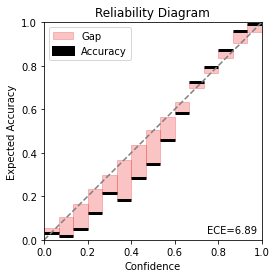

In [5]:
cur_val_ds,cur_val_idcs    = dm.get_current_validation_data()
val_inf_out  = calib.predict(cur_val_ds)

bin_data = compute_calibration(cur_val_ds.Y, val_inf_out['labels'], val_inf_out['confidence'], num_bins=15)
ax = plt.subplot()
reliability_diagram_subplot(ax, bin_data, draw_ece=True, draw_bin_importance=False, 
                             title="Reliability Diagram",  xlabel="Confidence", ylabel="Expected Accuracy",disable_labels=False)

<AxesSubplot:ylabel='Density'>

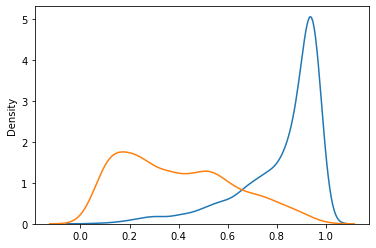

In [6]:
from utils.counting_utils import * 

out = get_scores_numbers(val_inf_out, cur_val_ds.Y,10)

sns.kdeplot(out['correct_scores'])
sns.kdeplot(out['incorrect_scores'])


In [7]:
dm.unmark_auto_labeled()

conf.auto_lbl_conf.C_1 =0.25
auto_labeler = AutoLabeling(conf,dm,pl.cur_clf,logger,calibrator=calib)
out = auto_labeler.run()
out = dm.get_auto_labeling_counts()
print(out)

tensor(0.5527, device='cuda:0') tensor(0.6939, device='cuda:0')
tensor(0.5523, device='cuda:0') tensor(0.6850, device='cuda:0')
tensor(0.5515, device='cuda:0') tensor(0.6910, device='cuda:0')
{'auto_labeled_acc': 0.9794915616321299, 'coverage_1': 0.33435714285714285, 'coverage_2': 0}


: 

In [8]:
idx = np.where(val_inf_out['confidence']>=0.5)[0]
print(len(idx))
Y_hat_val =val_inf_out['labels']
err = np.sum( (Y_hat_val[idx]!=cur_val_ds.Y.detach().numpy()[idx]))/(len(idx)*1.0)
print(err, len(idx)/len(Y_hat_val))

2447
0.04086636697997548 0.4894


<AxesSubplot:ylabel='Density'>

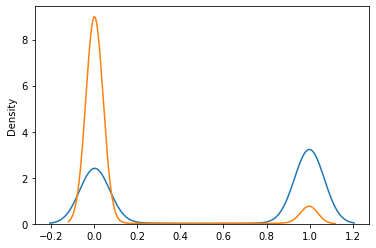

In [9]:
unlbld_idcs = dm.get_current_unlabeled_train_idcs() 
cur_unlbld_ds = dm.get_subset_dataset(unlbld_idcs)

unlbld_inf_out  = calib.predict(cur_unlbld_ds)

out = get_scores_numbers(unlbld_inf_out, cur_unlbld_ds.Y,10)

sns.kdeplot(out['correct_scores'])
sns.kdeplot(out['incorrect_scores'])


In [20]:
idx = np.where(unlbld_inf_out['confidence']>=0.9999)[0]

print(len(idx))
Y_hat_unlbld =unlbld_inf_out['labels']

err = np.sum( Y_hat_unlbld[idx]!=cur_unlbld_ds.Y.detach().numpy()[idx])/(len(idx)*1.0)
print(err, len(idx)/len(Y_hat_unlbld))

9688
0.0754541701073493 0.29258274945639046
